## Dependencies

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
import pandas as pd
from download import download_data_and_parse_it
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split
import time
import os


from sklearn.metrics import accuracy_score

batch_size = 32
num_classes = 12
learning_rate = 0.001
num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Create the dataset

In [4]:
# Load the JSON file into a DataFrame
datasets = [
        "star", "sword", "tent", "apple", "banana", "cat", 
        "dog", "car", "house", "tree", "guitar", "bicycle"
    ]
    
all_dfs = []  # List to store all DataFrames
for dataset in datasets:
    file_path = os.path.join("data", f"{dataset}.ndjson")
    dataset_df = download_data_and_parse_it(file_path)
    all_dfs.append(dataset_df)
# Combine all datasets
df = pd.concat(all_dfs, ignore_index=True)

# Assign class labels using LabelEncoder
le = LabelEncoder()
df['class'] = le.fit_transform(df['word'])

# Split into training, validation, and testing sets
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)  # 60% train, 40% temp
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # Split temp into 20% val, 20% test

print("size of datasets array :", len(datasets))

The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
size of datasets array : 12


## Google Vector-To-Image Algorithm - Drawing-to-image changed

In [5]:
import torch
from torch.utils.data import Dataset
import numpy as np
from PIL import Image

class QuickDrawDataset(Dataset):
    def __init__(self, drawings, labels, resize_to=(64, 64)):
        """
        Args:
            drawings (list or array): List of drawing data (tensor or numpy arrays).
            labels (list or array): List of class labels corresponding to each drawing.
            resize_to (tuple): Target size for resizing the image.
        """
        self.drawings = drawings
        self.labels = labels
        self.resize_to = resize_to  # Tuple (width, height)

    def __len__(self):
        return len(self.drawings)

    def __getitem__(self, idx):
        # Convert the drawing format to image
        drawing = self.drawings.iloc[idx] if isinstance(self.drawings, pd.Series) else self.drawings[idx]
        image = self.drawing_to_image(drawing)
        label = self.labels.iloc[idx] if isinstance(self.labels, pd.Series) else self.labels[idx]
        
        # Convert the image to a tensor and add batch dimension
        image_tensor = torch.FloatTensor(image).unsqueeze(0)
        return image_tensor, label

    def drawing_to_image(self, drawing):
        # Create a blank 256x256 image
        img_size = 256
        image = np.zeros((img_size, img_size), dtype=np.uint8)
        
        # Iterate through the strokes
        for stroke in drawing:
            x_coords = stroke[0]
            y_coords = stroke[1]

            # For each stroke, draw lines between consecutive points
            for i in range(len(x_coords) - 1):
                x1, y1 = int(x_coords[i]), int(y_coords[i])
                x2, y2 = int(x_coords[i + 1]), int(y_coords[i + 1])

                # Ensure that coordinates stay within bounds
                x1 = max(0, min(x1, img_size - 1))
                y1 = max(0, min(y1, img_size - 1))
                x2 = max(0, min(x2, img_size - 1))
                y2 = max(0, min(y2, img_size - 1))

                # Draw line on image (we simply put the endpoints as pixels here)
                image[y1, x1] = 255
                image[y2, x2] = 255
        
        # Resize the image to the desired size (64x64)
        pil_image = Image.fromarray(image)  # Convert to PIL Image
        pil_image = pil_image.resize(self.resize_to, Image.Resampling.LANCZOS)  # Resize image
        
        # Convert back to numpy array
        resized_image = np.array(pil_image)
        return resized_image


## Datasets

In [6]:
# # Create datasets
# train_dataset = QuickDrawDataset(train_df['drawing'], train_df['class'])
# val_dataset = QuickDrawDataset(val_df['drawing'], val_df['class'])
# test_dataset = QuickDrawDataset(test_df['drawing'], test_df['class'])

# # Create DataLoaders
# from torch.utils.data import DataLoader
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the datasets with resizing
train_dataset = QuickDrawDataset(train_df['drawing'], train_df['class'], resize_to=(64, 64))
val_dataset = QuickDrawDataset(val_df['drawing'], val_df['class'], resize_to=(64, 64))
test_dataset = QuickDrawDataset(test_df['drawing'], test_df['class'], resize_to=(64, 64))


# Create DataLoaders
from torch.utils.data import DataLoader
batch_size = 32  # Example batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Try to visualize some entries

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), np.int64(6))


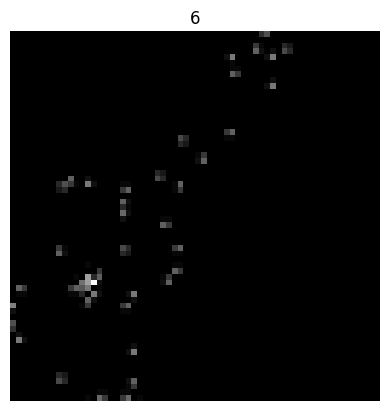

In [7]:
drawing = train_dataset.__getitem__(15000)

print(drawing)
import matplotlib.pyplot as plt

# Visualize the image
plt.imshow(drawing[0].squeeze(), cmap='gray')  # Squeeze to remove the single channel dimension
plt.axis('off')  # Hide axis for better visualization
plt.title(drawing[1])
plt.show()

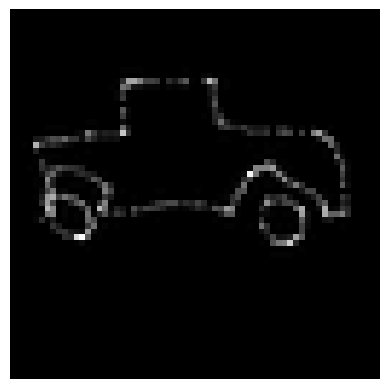

In [29]:
drawing = [[[48.22564697265625,45.22564697265625,40.22564697265625,37.22564697265625,33.22564697265625,30.22564697265625,28.22564697265625,25.22564697265625,25.22564697265625,25.22564697265625,25.22564697265625,26.22564697265625,27.22564697265625,28.22564697265625,31.22564697265625,31.22564697265625,35.22564697265625,37.22564697265625,39.22564697265625,42.22564697265625,44.22564697265625,46.22564697265625,48.22564697265625,50.22564697265625,52.22564697265625,52.22564697265625,54.22564697265625,54.22564697265625,54.22564697265625,55.22564697265625,55.22564697265625,56.22564697265625,56.22564697265625,56.22564697265625,56.22564697265625,55.22564697265625,53.22564697265625,53.22564697265625,52.22564697265625,52.22564697265625,50.22564697265625,49.22564697265625,48.22564697265625,47.22564697265625,46.22564697265625,45.22564697265625,45.22564697265625],[157.2708282470703,156.2708282470703,156.2708282470703,155.2708282470703,152.2708282470703,150.2708282470703,145.2708282470703,140.2708282470703,138.2708282470703,135.2708282470703,134.2708282470703,131.2708282470703,130.2708282470703,129.2708282470703,129.2708282470703,129.2708282470703,129.2708282470703,129.2708282470703,130.2708282470703,131.2708282470703,131.2708282470703,132.2708282470703,134.2708282470703,134.2708282470703,136.2708282470703,136.2708282470703,139.2708282470703,140.2708282470703,143.2708282470703,144.2708282470703,146.2708282470703,147.2708282470703,147.2708282470703,149.2708282470703,150.2708282470703,152.2708282470703,154.2708282470703,155.2708282470703,156.2708282470703,157.2708282470703,158.2708282470703,158.2708282470703,158.2708282470703,158.2708282470703,158.2708282470703,157.2708282470703,157.2708282470703],[1,3,21,39,57,75,93,111,129,147,165,182,200,217,235,252,270,289,307,324,343,361,379,396,415,433,451,468,487,505,522,541,559,576,593,611,629,646,670,691,736,758,772,789,807,825,843]],[[185.22564697265625,182.22564697265625,180.22564697265625,176.22564697265625,175.22564697265625,174.22564697265625,174.22564697265625,175.22564697265625,176.22564697265625,176.22564697265625,177.22564697265625,178.22564697265625,178.22564697265625,179.22564697265625,182.22564697265625,186.22564697265625,189.22564697265625,191.22564697265625,193.22564697265625,198.22564697265625,199.22564697265625,200.22564697265625,201.22564697265625,202.22564697265625,202.22564697265625,202.22564697265625,202.22564697265625,202.22564697265625,202.22564697265625,202.22564697265625,201.22564697265625,201.22564697265625,200.22564697265625,199.22564697265625,198.22564697265625,197.22564697265625,195.22564697265625,195.22564697265625,194.22564697265625,193.22564697265625,192.22564697265625,191.22564697265625,189.22564697265625,187.22564697265625,185.22564697265625,183.22564697265625],[161.2708282470703,160.2708282470703,157.2708282470703,152.2708282470703,150.2708282470703,149.2708282470703,146.2708282470703,139.2708282470703,135.2708282470703,135.2708282470703,132.2708282470703,132.2708282470703,132.2708282470703,132.2708282470703,132.2708282470703,131.2708282470703,131.2708282470703,132.2708282470703,133.2708282470703,136.2708282470703,136.2708282470703,137.2708282470703,139.2708282470703,139.2708282470703,140.2708282470703,141.2708282470703,144.2708282470703,145.2708282470703,148.2708282470703,151.2708282470703,155.2708282470703,155.2708282470703,157.2708282470703,157.2708282470703,158.2708282470703,159.2708282470703,161.2708282470703,161.2708282470703,161.2708282470703,161.2708282470703,161.2708282470703,161.2708282470703,161.2708282470703,161.2708282470703,161.2708282470703,161.2708282470703],[1589,1603,1621,1639,1657,1674,1692,1710,1728,1746,1764,1787,1806,1819,1837,1855,1873,1891,1911,1928,1947,1965,1984,2001,2020,2038,2056,2074,2091,2109,2127,2145,2164,2182,2205,2217,2235,2253,2271,2288,2306,2325,2343,2361,2380,2386]],[[21.22564697265625,22.22564697265625,23.22564697265625,25.22564697265625,26.22564697265625,27.22564697265625,28.22564697265625,30.22564697265625,31.22564697265625,33.22564697265625,37.22564697265625,41.22564697265625,46.22564697265625,49.22564697265625,55.22564697265625,57.22564697265625,60.22564697265625,62.22564697265625,66.22564697265625,67.22564697265625,67.22564697265625,67.22564697265625,67.22564697265625,67.22564697265625,66.22564697265625,65.22564697265625,65.22564697265625,64.22564697265625,63.22564697265625,62.22564697265625,62.22564697265625,63.22564697265625,63.22564697265625,65.22564697265625,68.22564697265625,74.22564697265625,76.22564697265625,85.22564697265625,87.22564697265625,92.22564697265625,96.22564697265625,100.22564697265625,103.22564697265625,106.22564697265625,110.22564697265625,112.22564697265625,116.22564697265625,122.22564697265625,127.22564697265625,130.22564697265625,133.22564697265625,140.22564697265625,143.22564697265625,146.22564697265625,148.22564697265625,149.22564697265625,150.22564697265625,151.22564697265625,153.22564697265625,153.22564697265625,154.22564697265625,154.22564697265625,154.22564697265625,155.22564697265625,156.22564697265625,158.22564697265625,160.22564697265625,160.22564697265625,161.22564697265625,162.22564697265625,163.22564697265625,165.22564697265625,165.22564697265625,166.22564697265625,166.22564697265625,167.22564697265625,168.22564697265625,169.22564697265625,170.22564697265625,172.22564697265625,172.22564697265625,173.22564697265625,176.22564697265625,177.22564697265625,178.22564697265625,178.22564697265625,180.22564697265625,180.22564697265625,182.22564697265625,182.22564697265625,184.22564697265625,186.22564697265625,187.22564697265625,189.22564697265625,190.22564697265625,191.22564697265625,195.22564697265625,195.22564697265625,197.22564697265625,198.22564697265625,202.22564697265625,207.22564697265625,208.22564697265625,212.22564697265625,215.22564697265625,216.22564697265625,216.22564697265625,217.22564697265625,218.22564697265625,218.22564697265625,218.22564697265625,218.22564697265625,218.22564697265625,218.22564697265625,220.22564697265625,223.22564697265625,225.22564697265625,228.22564697265625,230.22564697265625,230.22564697265625,231.22564697265625,232.22564697265625,232.22564697265625,231.22564697265625,231.22564697265625,230.22564697265625,230.22564697265625,230.22564697265625,230.22564697265625,230.22564697265625,230.22564697265625,227.22564697265625,226.22564697265625,226.22564697265625,224.22564697265625,222.22564697265625,222.22564697265625,221.22564697265625,218.22564697265625,217.22564697265625,215.22564697265625,213.22564697265625,212.22564697265625,211.22564697265625,210.22564697265625,202.22564697265625,193.22564697265625,191.22564697265625,188.22564697265625,186.22564697265625,178.22564697265625,174.22564697265625,169.22564697265625,165.22564697265625,161.22564697265625,155.22564697265625,150.22564697265625,147.22564697265625,145.22564697265625,145.22564697265625,145.22564697265625,144.22564697265625,144.22564697265625,143.22564697265625,141.22564697265625,141.22564697265625,141.22564697265625,140.22564697265625,140.22564697265625,140.22564697265625,140.22564697265625,140.22564697265625,138.22564697265625,136.22564697265625,135.22564697265625,122.22564697265625,120.22564697265625,116.22564697265625,110.22564697265625,102.22564697265625,98.22564697265625,95.22564697265625,91.22564697265625,90.22564697265625,89.22564697265625,86.22564697265625,85.22564697265625,84.22564697265625,83.22564697265625,82.22564697265625,80.22564697265625,80.22564697265625,78.22564697265625,78.22564697265625,77.22564697265625,77.22564697265625,78.22564697265625,78.22564697265625,78.22564697265625,78.22564697265625,78.22564697265625,79.22564697265625,79.22564697265625,79.22564697265625,78.22564697265625,77.22564697265625,72.22564697265625,66.22564697265625,60.22564697265625,56.22564697265625,55.22564697265625,53.22564697265625,52.22564697265625,46.22564697265625,41.22564697265625,38.22564697265625,36.22564697265625,33.22564697265625,31.22564697265625,28.22564697265625,26.22564697265625,21.22564697265625,18.22564697265625,18.22564697265625,18.22564697265625,18.22564697265625,22.22564697265625,23.22564697265625,24.22564697265625,26.22564697265625,27.22564697265625,28.22564697265625,28.22564697265625,28.22564697265625,28.22564697265625,28.22564697265625,28.22564697265625,28.22564697265625,28.22564697265625,28.22564697265625,28.22564697265625,28.22564697265625,28.22564697265625,28.22564697265625,28.22564697265625,28.22564697265625,28.22564697265625,28.22564697265625],[145.2708282470703,133.2708282470703,128.2708282470703,122.27082824707031,119.27082824707031,117.27082824707031,114.27082824707031,112.27082824707031,111.27082824707031,110.27082824707031,110.27082824707031,110.27082824707031,111.27082824707031,112.27082824707031,115.27082824707031,117.27082824707031,118.27082824707031,120.27082824707031,122.27082824707031,123.27082824707031,124.27082824707031,125.27082824707031,127.27082824707031,130.2708282470703,132.2708282470703,134.2708282470703,134.2708282470703,135.2708282470703,136.2708282470703,136.2708282470703,138.2708282470703,139.2708282470703,140.2708282470703,140.2708282470703,140.2708282470703,140.2708282470703,140.2708282470703,139.2708282470703,139.2708282470703,138.2708282470703,137.2708282470703,136.2708282470703,135.2708282470703,135.2708282470703,134.2708282470703,134.2708282470703,134.2708282470703,134.2708282470703,135.2708282470703,135.2708282470703,135.2708282470703,137.2708282470703,137.2708282470703,139.2708282470703,139.2708282470703,139.2708282470703,139.2708282470703,139.2708282470703,140.2708282470703,140.2708282470703,140.2708282470703,138.2708282470703,135.2708282470703,131.2708282470703,131.2708282470703,127.27082824707031,126.27082824707031,124.27082824707031,122.27082824707031,121.27082824707031,117.27082824707031,116.27082824707031,114.27082824707031,114.27082824707031,113.27082824707031,113.27082824707031,112.27082824707031,111.27082824707031,111.27082824707031,110.27082824707031,110.27082824707031,110.27082824707031,110.27082824707031,109.27082824707031,107.27082824707031,107.27082824707031,107.27082824707031,108.27082824707031,110.27082824707031,111.27082824707031,112.27082824707031,114.27082824707031,115.27082824707031,116.27082824707031,118.27082824707031,119.27082824707031,120.27082824707031,120.27082824707031,121.27082824707031,122.27082824707031,123.27082824707031,126.27082824707031,126.27082824707031,129.2708282470703,131.2708282470703,134.2708282470703,135.2708282470703,136.2708282470703,138.2708282470703,139.2708282470703,140.2708282470703,141.2708282470703,143.2708282470703,143.2708282470703,143.2708282470703,142.2708282470703,141.2708282470703,141.2708282470703,140.2708282470703,140.2708282470703,140.2708282470703,139.2708282470703,139.2708282470703,132.2708282470703,131.2708282470703,121.27082824707031,120.27082824707031,115.27082824707031,112.27082824707031,109.27082824707031,107.27082824707031,104.27082824707031,101.27082824707031,100.27082824707031,95.27082824707031,93.27082824707031,91.27082824707031,90.27082824707031,89.27082824707031,88.27082824707031,87.27082824707031,86.27082824707031,85.27082824707031,85.27082824707031,85.27082824707031,85.27082824707031,85.27082824707031,84.27082824707031,84.27082824707031,84.27082824707031,84.27082824707031,84.27082824707031,84.27082824707031,84.27082824707031,82.27082824707031,81.27082824707031,80.27082824707031,80.27082824707031,79.27082824707031,79.27082824707031,79.27082824707031,76.27082824707031,75.27082824707031,71.27082824707031,67.27082824707031,65.27082824707031,61.27082824707031,58.27082824707031,53.27082824707031,51.27082824707031,50.27082824707031,49.27082824707031,49.27082824707031,49.27082824707031,49.27082824707031,50.27082824707031,50.27082824707031,50.27082824707031,50.27082824707031,50.27082824707031,50.27082824707031,50.27082824707031,50.27082824707031,50.27082824707031,50.27082824707031,50.27082824707031,50.27082824707031,50.27082824707031,50.27082824707031,51.27082824707031,51.27082824707031,52.27082824707031,52.27082824707031,54.27082824707031,58.27082824707031,61.27082824707031,69.27082824707031,71.27082824707031,75.27082824707031,81.27082824707031,83.27082824707031,84.27082824707031,84.27082824707031,85.27082824707031,86.27082824707031,86.27082824707031,87.27082824707031,87.27082824707031,87.27082824707031,87.27082824707031,87.27082824707031,87.27082824707031,87.27082824707031,89.27082824707031,90.27082824707031,90.27082824707031,90.27082824707031,91.27082824707031,91.27082824707031,91.27082824707031,91.27082824707031,92.27082824707031,92.27082824707031,93.27082824707031,94.27082824707031,96.27082824707031,105.27082824707031,109.27082824707031,112.27082824707031,116.27082824707031,120.27082824707031,124.27082824707031,125.27082824707031,127.27082824707031,127.27082824707031,128.2708282470703,129.2708282470703,129.2708282470703,131.2708282470703,133.2708282470703,135.2708282470703,137.2708282470703,138.2708282470703,139.2708282470703,140.2708282470703,140.2708282470703,141.2708282470703,142.2708282470703],[3125,3135,3152,3169,3187,3205,3223,3241,3259,3277,3295,3312,3330,3348,3366,3385,3402,3420,3438,3456,3476,3492,3510,3528,3545,3563,3581,3599,3617,3635,3661,3678,3689,3707,3725,3743,3761,3778,3796,3814,3832,3850,3868,3887,3904,3922,3941,3958,3976,3994,4012,4030,4048,4066,4084,4102,4131,4138,4156,4174,4192,4287,4306,4324,4343,4361,4379,4397,4415,4432,4450,4468,4486,4504,4522,4550,4567,4576,4594,4612,4630,4649,4667,4684,4703,4726,4739,4757,4775,4796,4811,4828,4846,4864,4882,4901,4918,4936,4954,4972,4990,5008,5026,5044,5062,5080,5098,5116,5135,5153,5171,5190,5243,5408,5426,5444,5463,5482,5500,5557,5575,5672,5691,5709,5728,5746,5765,5782,5801,5819,5837,5855,5873,5891,5909,5927,5945,5962,5980,5998,6016,6034,6052,6071,6089,6107,6125,6143,6161,6178,6197,6214,6232,6250,6268,6286,6305,6322,6341,6359,6416,6434,6452,6470,6488,6506,6524,6542,6560,6578,6596,6736,6754,6772,6790,6808,6832,6844,6862,6879,6897,6916,6934,6952,7006,7023,7041,7059,7078,7096,7114,7132,7151,7168,7186,7205,7223,7242,7259,7277,7295,7313,7423,7449,7460,7477,7495,7513,7531,7550,7567,7586,7603,7621,7639,7657,7675,7694,7712,7730,7749,7767,7785,7897,7915,7933,7951,7969,7986,8004,8021,8039,8056,8074,8093,8118,8137,8146,8164,8182,8200,8218,8236,8254,8272,8290,8375,8393]]]
reconstructed_image = train_dataset.drawing_to_image(drawing)
plt.imshow(reconstructed_image, cmap='gray')
plt.axis('off')
plt.show()


# Example input data (simplified vector data from the NDJSON)
# drawings = [
#     [[[4,18,29,63,93,120,146,169,186,218,244,234,186,154,128,86,44,14,0],[7,51,66,90,101,106,106,101,93,67,22,23,49,58,59,53,26,16,6]],[[10,27,42,78,135,162,212,230,244],[15,39,53,67,80,74,48,35,20]],[[9,2,16,22,23,20],[18,3,0,3,8,20]],[[229,244,254,252,241],[23,17,18,22,30]],[[52,52],[52,52]],[[52,50],[52,52]],[[59,43],[69,61]]],
#     [[[223,226,227,233,254,255,248,227],[35,25,2,0,2,21,27,30]],[[234,235,244,246,249],[4,8,12,19,20]],[[232,208,168,135,98,37],[28,51,104,138,164,196]],[[255,255,245,194,182,172,115,26,18,8],[25,61,106,199,213,217,219,235,235,230]],[[12,1,0,0,10,22,29,28,16,11],[193,191,194,206,219,218,206,199,194,197]],[[41,29,12],[232,228,217]],[[7,7,12,14,14,18,19,23,27,29,37],[186,199,190,193,209,200,204,204,194,203,192]],[[230,230,235,238,241,245,245],[8,15,8,17,16,4,11]],[[251,251,241,235,211,191,121,59,31],[26,69,113,126,155,168,200,215,215]],[[214,201,177,153,120,108],[72,102,131,152,167,175]]], 
#     [[[2,0,4,24,41,94,160,186,189,177,151,134,94,71,30],[0,38,79,138,162,207,247,255,251,238,218,200,139,98,45]]]
# ]

# # Reconstruct the image from the simplified drawing
# index = 0
# for drawing in drawings:
#     reconstructed_image = train_dataset.drawing_to_image(drawing)
#     index+=1
#     # Display the image
#     plt.imshow(reconstructed_image, cmap='gray')
#     plt.title(index)
#     plt.axis('off')
#     plt.show()

## Just a resizing test

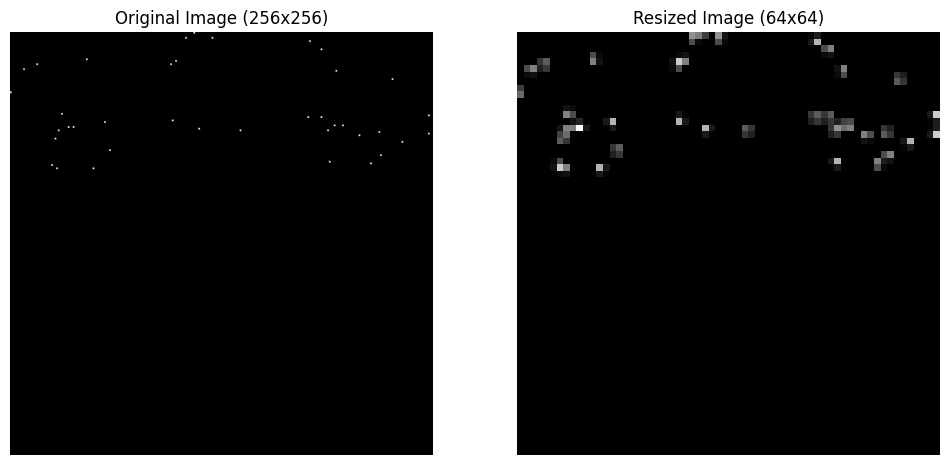

In [14]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T
import numpy as np

# Assuming `drawing` is the tuple as described
image_tensor = drawing[0]  # Image tensor of shape (1, H, W)
label = drawing[1]         # The label (in this case, 3)

# Convert the image to 3D (H, W, C) for easier manipulation
image_numpy = image_tensor.squeeze().cpu().numpy()

# Resize the image to a smaller size using a transformation (e.g., 128x128)
resize_transform = T.Resize((64, 64))  # Resize to 128x128
resized_image_tensor = resize_transform(image_tensor.unsqueeze(0))  # Add batch dimension

# Convert back to numpy array for visualization
resized_image_numpy = resized_image_tensor.squeeze().cpu().numpy()

# Visualize the original and resized image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original image
ax[0].imshow(image_numpy, cmap='gray')
ax[0].set_title("Original Image (256x256)")
ax[0].axis('off')

# Resized image
ax[1].imshow(resized_image_numpy, cmap='gray')
ax[1].set_title("Resized Image (64x64)")
ax[1].axis('off')

plt.show()

## Train and test algorithms

In [6]:
# Training loop
def train_model(model, optimizer, criterion):
    model.train()
    for epoch in range(num_epochs):  # Number of epochs
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

# Testing loop
def test_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")


## Model

In [31]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16*16, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

## Run the model

In [32]:
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
print("model structure", model)

start_time = time.time()

train_model(model, optimizer, criterion)
test_model(model)

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

model structure SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=12, bias=True)
  )
)
Epoch 1, Loss: 0.4110197599155996
Epoch 2, Loss: 0.31496348395428075
Epoch 3, Loss: 0.2823221774107087
Epoch 4, Loss: 0.259060027471739
Epoch 5, Loss: 0.23983934732956932
Epoch 6, Loss: 0.22329707152937295
Epoch 7, Loss: 0.2094609522234722
Epoch 8, Loss: 0.19705468979870466
Epoch 9, Loss: 0.18663024016773255
Epoch 10, Loss: 0.1772725153415165
Accuracy: 89.34%
Execution time

## Save the model

In [33]:
# Save the trained model to a file
model_file_path = "best_model2.pth"
torch.save(model.state_dict(), model_file_path)
print(f"Model saved to {model_file_path}")

Model saved to best_model2.pth


## Two other models

### Lighter

In [38]:
class EfficientCNN(nn.Module):
    def __init__(self, num_classes):
        super(EfficientCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # 1 input channel, 16 filters
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Reduce size by half
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 64),  # Fewer neurons in FC layer
            nn.ReLU(),
            nn.Linear(64, num_classes),
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x
    
lightModel = EfficientCNN(num_classes).to(device)
optimizer = optim.Adam(lightModel.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
print("lightModel structure", lightModel)

start_time = time.time()

train_model(lightModel, optimizer, criterion)
test_model(lightModel)

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

lightModel structure EfficientCNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=12, bias=True)
  )
)
Epoch 1, Loss: 0.4318207372455258
Epoch 2, Loss: 0.338471194588679
Epoch 3, Loss: 0.30951562185115966
Epoch 4, Loss: 0.29060624745590086
Epoch 5, Loss: 0.27626049889245025
Epoch 6, Loss: 0.2647074138012333
Epoch 7, Loss: 0.25459925987843174
Epoch 8, Loss: 0.24577768132687794
Epoch 9, Loss: 0.23832450930444152
Epoch 10, Loss: 0.231188982910864
Accuracy: 89.33%
Executio

### Deeper

In [19]:
class EnhancedCNN(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),  # Normalize feature maps for faster convergence
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Add a third convolutional layer
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),  # More neurons for higher capacity
            nn.ReLU(),
            nn.Dropout(0.5),  # Add dropout for regularization
            nn.Linear(256, num_classes),
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x
    
deepModel = EnhancedCNN(num_classes).to(device)
# optimizer = optim.Adam(deepModel.parameters(), lr=learning_rate)
# criterion = nn.CrossEntropyLoss()
# print("lightModel structure", deepModel)

# start_time = time.time()

# train_model(deepModel, optimizer, criterion)
# test_model(deepModel)

# end_time = time.time()

# execution_time = end_time - start_time
# print(f"Execution time: {execution_time:.6f} seconds")


In [40]:
# Save the trained model to a file
model_file_path = "deepest_model.pth"
torch.save(deepModel.state_dict(), model_file_path)
print(f"Model saved to {model_file_path}")

Model saved to deepest_model.pth


## Two deeper models

In [17]:
from torch.optim.lr_scheduler import StepLR

def train_model_with_scheduler(model, optimizer, scheduler, criterion, num_epochs=10):
    print(num_epochs)
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Update learning rate
        scheduler.step()
        
        # Print metrics
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
        for param_group in optimizer.param_groups:
            print(f"Learning Rate: {param_group['lr']}")


In [18]:
class ResNetLikeCNN(nn.Module):
    def __init__(self, num_classes):
        super(ResNetLikeCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Shortcut connection to match the channel dimensions
        self.shortcut = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1, stride=1),  # Match input to output channels
            nn.BatchNorm2d(128)
        )

        self.pool = nn.AdaptiveAvgPool2d((8, 8))  # Ensure consistent spatial dimensions
        self.fc = None  # Placeholder, will be dynamically initialized
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))  # First convolution
        x = torch.relu(self.bn2(self.conv2(x)))  # Second convolution
        residual = self.shortcut(x)              # Adjust dimensions for residual
        x = torch.relu(self.bn3(self.conv3(x)) + residual)  # Add residual to output
        x = self.pool(x)  # Downsample to fixed size
        x = torch.flatten(x, 1)  # Flatten before fully connected layers
        x = self.fc(x)  # Fully connected layers
        return x

    def initialize_fc(self, input_shape):
        # Dynamically calculate the input size of the flattened feature map
        dummy_input = torch.zeros(input_shape)  # Create a dummy tensor with input shape
        conv_output = self.conv1(dummy_input)  # Pass through layers to determine flattened size
        conv_output = torch.relu(self.bn1(conv_output))
        conv_output = torch.relu(self.bn2(self.conv2(conv_output)))
        residual = self.shortcut(conv_output)
        conv_output = torch.relu(self.bn3(self.conv3(conv_output)) + residual)
        conv_output = self.pool(conv_output)
        flattened_size = torch.flatten(conv_output, 1).shape[1]  # Calculate flattened size
        
        # Define the fully connected layers dynamically
        self.fc = nn.Sequential(
            nn.Linear(flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

# Define number of classes and input shape
input_shape = (1, 1, 64, 64)  # Batch size of 1, 1 channel, 64x64 image size

# Instantiate the model and initialize fully connected layers
deeper1Model = ResNetLikeCNN(num_classes=num_classes)
deeper1Model.initialize_fc(input_shape)

# Move model to the device
deeper1Model = deeper1Model.to(device)

# Define optimizer, scheduler, and criterion
optimizer = optim.Adam(deeper1Model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
criterion = nn.CrossEntropyLoss()

# Print model structure
print("ResNetLikeCNN structure:")
print(deeper1Model)

# Training and testing
start_time = time.time()
train_model(deeper1Model, optimizer, scheduler, criterion, num_epochs)
test_model(deeper1Model)
end_time = time.time()

# Print execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

# Save the trained model
model_file_path = "deeper1_model_dynamic.pth"
torch.save(deeper1Model.state_dict(), model_file_path)
print(f"Model saved to {model_file_path}")

ResNetLikeCNN structure:
ResNetLikeCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool): AdaptiveAvgPool2d(output_size=(8, 8))
  (fc): Sequential(
    (0): Linear(in_features=8192, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=12, bias=True)
  )
)
Epoch [1/10], Loss: 0.5782
E

In [19]:
class DeeperCNN2(nn.Module):
    def __init__(self, num_classes):
        super(DeeperCNN2, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc1 = None  # Placeholder, will be initialized dynamically
        self.fc2 = nn.Linear(512, num_classes)  # Output layer for classification

    def forward(self, x):
        x = self.conv_layers(x)  # Pass through convolutional layers
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch size
        x = self.fc1(x)  # First fully connected layer
        x = self.fc2(x)  # Output layer
        return x

    def initialize_fc(self, input_shape):
        # Dynamically calculate the input size of the flattened feature map
        dummy_input = torch.zeros(input_shape)  # Create a dummy tensor with input shape
        conv_output = self.conv_layers(dummy_input)  # Pass through conv layers
        flattened_size = torch.flatten(conv_output, 1).shape[1]  # Calculate flattened size
        self.fc1 = nn.Linear(flattened_size, 512)  # Initialize fc1 with calculated size


input_shape = (1, 1, 64, 64)  # Batch size of 1, 1 channel, 64x64 image size

# Instantiate the model and initialize fully connected layer
deeper2Model = DeeperCNN2(num_classes=num_classes)
deeper2Model.initialize_fc(input_shape)

# Move model to the device
deeper2Model = deeper2Model.to(device)

# Define optimizer, scheduler, and criterion
optimizer = optim.Adam(deeper2Model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
criterion = nn.CrossEntropyLoss()

# Print model structure
print("DeeperCNN2 structure:")
print(deeper2Model)

# Training and testing
start_time = time.time()
train_model(deeper2Model, optimizer, scheduler, criterion, num_epochs)
test_model(deeper2Model)
end_time = time.time()

# Print execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

# Save the trained model
model_file_path = "deeper2_model_dynamic.pth"
torch.save(deeper2Model.state_dict(), model_file_path)
print(f"Model saved to {model_file_path}")

DeeperCNN2 structure:
DeeperCNN2(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc2): Linear(in_features=512, out_features=12, bias=True)
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
)
Epoch [1/10], Loss: 0.4659
Epoch [2/10], Loss: 0.3979
Epoch [3/10], Loss: 0.3839
Epoch [4/10], Loss: 0.3762
Epoch [5/10], Loss: 0.3717
Epoch [6/10], Loss: 0.3676
Epoch [7/10], Loss: 0.3643
Epoch [8/10], Loss: 0.3627
Epoch [9/10], Loss: 0.3605
Epoch [10/10], Loss: 0.3589
Accuracy: 8

Predicted Class: 9


/tmp/ipykernel_20213/2596780188.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("deepest_model.pth", map_location=torch.device('cpu')))


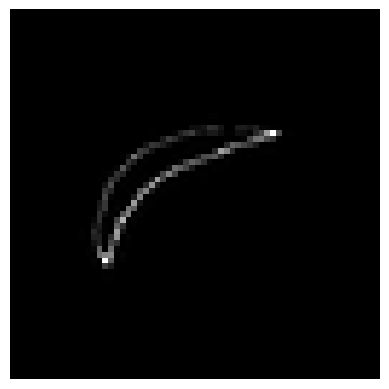

In [27]:
from torchvision.transforms import ToTensor



num_classes = 12
model = EnhancedCNN(num_classes)
model.load_state_dict(torch.load("deepest_model.pth", map_location=torch.device('cpu')))
model.eval()

transform = ToTensor()
input_image = transform(reconstructed_image).unsqueeze(0)

with torch.no_grad():
    output = model(input_image)
    predicted_class = torch.argmax(output, dim=1).item()

print(f"Predicted Class: {predicted_class}")
